In [ ]:
!unzip -q /content/drive/MyDrive/도서_추천.zip

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 12.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import random
import os
import gc
from tqdm import tqdm

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(113) # Seed 고정

In [ ]:
train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv( 'test.csv', encoding='utf-8')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0, encoding='utf-8')

In [ ]:
import re
def preprocessing_data(df):

    # 데이터 정리
    df['Book-Title'] = [re.sub(r'[^0-9a-zA-Z:,]',  ' ',str(i)) for i in df['Book-Title']]
    df['Main_Title'] = [i.split('  ')[0] for i in df['Book-Title']]
    df['Sub_Title'] = [''.join(i.split('  ')[1:]) for i in df['Book-Title']]
    df['Sub_Title'] = np.where(df['Sub_Title'] == '', 'No_SUB', df['Sub_Title'])

    df['Location'] = [re.sub(r'[^0-9a-zA-Z:,]',  ' ',str(i)) for i in df['Location']]

    df['City'] = [(i.split(',')[0]).lstrip().lower() for i in df['Location']]
    df['State'] = [(i.split(',')[1]).lstrip().lower() for i in df['Location']]
    df['Country'] = [(i.split(',')[2]).lstrip().lower() for i in df['Location']]

    # preprocessing Location
    # NaN, N/A, etc.. Change 'unknown'
    # Only using Train Data	#

    # 최빈값을 사용하기 위해 새로운 데이터 프레임 생성(pd.Series.mode를 이용하면 같은 count수의 값을 list로 묶어서 정확하지 않음)
    new_state = train_lb.groupby(['City'])['State'].value_counts().to_frame().rename(columns = {'State' : 'count'}).reset_index()
    new_state = new_state[(~new_state['City'].isna())&(~new_state['State'].isna())&(new_state['count']!=1)]
    new_state = new_state.sort_values(by=['City', 'count'], ascending=[True, False]).drop_duplicates(subset='City', keep='first')
    new_state = new_state.rename(columns = {'State' : 'N_State'})
    new_state = new_state.drop(columns = ['count'])

    new_country = train_lb.groupby(['State'])['Country'].value_counts().to_frame().rename(columns = {'Country' : 'count'}).reset_index()
    new_country = new_country[(~new_country['State'].isna())&(~new_country['Country'].isna())&(new_country['count']!=1)]
    new_country = new_country.sort_values(by=['State', 'count'], ascending=[True, False]).drop_duplicates(subset='State', keep='first')
    new_country = new_country.rename(columns = {'Country' : 'N_Country'})
    new_country = new_country.drop(columns = ['count'])

    df = pd.merge(df, new_country, on = 'State', how = 'left')
    df = pd.merge(df, new_state, on = 'City', how = 'left')

    df['Country'] = np.where((df['Country'] == '')|(df['Country'].astype(str) == 'nan'), df['N_Country'], df['Country'])
    df['State'] = np.where((df['State'] == '')|(df['State'].astype(str) == 'nan'), df['N_State'], df['State'])

    # 채워지지 않은 값은 Unknown 처리
    df[['Country', 'State', 'City']] = df[['Country', 'State', 'City']].fillna(value= 'Unknown')
    df = df.drop(columns = ['N_Country', 'N_State'])

    return df


In [ ]:
def feature_engineering(df):
    labels = ['0-3','3-6','6-8','8-12','12-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
    bins = [0, 3, 6, 8, 12, 18, 25, 34, 44, 54, 64, 74, 250]

    # Age 이상치 처리
    #df['Age'] = df['Age'].apply(lambda x: 3 if x<3 else x)
    #df['Age'] = df['Age'].apply(lambda x: 100 if x>100 else x)

    df.loc[(df['Age'] > 90) | (df['Age'] < 3), 'Age'] = np.nan

    # 평균값으로 대체
    df['Age'] = df['Age'].fillna(train_lb['Age'].mean())
    df['Age'] = df['Age'].astype(np.int32)


    df['Age_gb'] = pd.cut(df.Age, bins, labels = labels,include_lowest = True)

    # 출판년도 그룹화
    # 만약 출판연도가 null이 있다면 정보없음(-1)로 채움
    #df['Year-Of-Publication'] = df['Year-Of-Publication'].fillna(-1)
    #labels = ['Unknown', '-1800', '1800-1850', '1850-1900', '1900-1910', '1910-1920', '1920-1930', '1930-1940', '1940-1950','1950-1960', '1960-1970', '1970-1980', '1980-1990', '1990-2000', '2000-2010', '2010-2020', '2020-']
    #bins = [-1, 0, 1800, 1850, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 3000]
    #df['Pub_gb'] = pd.cut(df['Year-Of-Publication'], bins, labels = labels,include_lowest = True)
    #df = df.drop(columns =['Year-Of-Publication'])

    return df

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings('ignore')

FEATURE = ['User-ID','Book-Title', 'Main_Title','Sub_Title','Book-Author','Publisher', 'City','State','Country','Age_gb']#, 'Pub_gb']#, 'Language'] ',

train_lb = train.__deepcopy__()
test_lb = test.__deepcopy__()

train_lb = preprocessing_data(train_lb)
test_lb = preprocessing_data(test_lb)

train_lb = feature_engineering(train_lb)
test_lb = feature_engineering(test_lb)

train_lb = train_lb.drop(columns = ['Book-ID', 'Location'])
test_lb = test_lb.drop(columns = ['Book-ID', 'Location'])

train_lb[FEATURE] = train_lb[FEATURE].astype(str)
test_lb[FEATURE] = test_lb[FEATURE].astype(str)

for i in FEATURE:
    # train에는 없고, test에는 있는 원소는 -2 처리
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-2)
    oe=oe.fit(train_lb[i].to_numpy().reshape(-1, 1))
    train_lb[i] = oe.transform(train_lb[i].to_numpy().reshape(-1, 1))
    test_lb[i] = oe.transform(test_lb[i].to_numpy().reshape(-1, 1))

In [ ]:
X_train = train_lb.drop(columns = ['ID' , 'Book-Title', 'Book-Rating'])
y_train = train_lb['Book-Rating']
x_test = test_lb.drop(columns = ['ID','Book-Title'])

In [ ]:
from catboost import CatBoostRegressor, Pool
model = CatBoostRegressor(random_seed = 113,
                          l2_leaf_reg = 0.003426034644149707,
                          max_bin = 358,
                          subsample = 0.9974697184313627,
                          learning_rate = 0.009464402227606937,
                          max_depth = 11,
                          min_data_in_leaf = 139,
                          eval_metric = 'RMSE',
                          iterations = 8694,
                          task_type='GPU',
                          bootstrap_type = 'Poisson',
                          early_stopping_rounds = 100,
                          verbose=500
                          )

0it [00:00, ?it/s]


Fold  0
0:	learn: 3.8400456	test: 3.8396211	best: 3.8396211 (0)	total: 55.1ms	remaining: 7m 59s
500:	learn: 3.3159642	test: 3.2881569	best: 3.2881569 (500)	total: 25.9s	remaining: 7m 4s
1000:	learn: 3.2725074	test: 3.2685493	best: 3.2685493 (1000)	total: 52.2s	remaining: 6m 40s
1500:	learn: 3.2420614	test: 3.2609226	best: 3.2609205 (1498)	total: 1m 18s	remaining: 6m 18s
2000:	learn: 3.2155972	test: 3.2566057	best: 3.2566057 (2000)	total: 1m 45s	remaining: 5m 54s
2500:	learn: 3.1908457	test: 3.2533466	best: 3.2533445 (2496)	total: 2m 13s	remaining: 5m 29s
3000:	learn: 3.1675494	test: 3.2513126	best: 3.2513112 (2999)	total: 2m 40s	remaining: 5m 4s
3500:	learn: 3.1457237	test: 3.2496013	best: 3.2495838 (3492)	total: 3m 8s	remaining: 4m 39s
4000:	learn: 3.1238906	test: 3.2482931	best: 3.2482931 (4000)	total: 3m 35s	remaining: 4m 12s
4500:	learn: 3.1031344	test: 3.2474332	best: 3.2474212 (4481)	total: 4m 3s	remaining: 3m 46s
5000:	learn: 3.0825174	test: 3.2464534	best: 3.2464470 (4984)	tot

1it [05:04, 304.21s/it]


Fold  1
0:	learn: 3.8400140	test: 3.8396554	best: 3.8396554 (0)	total: 50.9ms	remaining: 7m 22s
500:	learn: 3.3166221	test: 3.2781521	best: 3.2781521 (500)	total: 25.8s	remaining: 7m 2s
1000:	learn: 3.2728528	test: 3.2578642	best: 3.2578642 (1000)	total: 52.1s	remaining: 6m 40s
1500:	learn: 3.2417258	test: 3.2499270	best: 3.2499270 (1500)	total: 1m 18s	remaining: 6m 17s
2000:	learn: 3.2151828	test: 3.2451911	best: 3.2451911 (2000)	total: 1m 45s	remaining: 5m 54s
2500:	learn: 3.1910019	test: 3.2420335	best: 3.2420335 (2500)	total: 2m 13s	remaining: 5m 29s
3000:	learn: 3.1676781	test: 3.2398484	best: 3.2398484 (3000)	total: 2m 40s	remaining: 5m 4s
3500:	learn: 3.1455385	test: 3.2380960	best: 3.2380960 (3500)	total: 3m 8s	remaining: 4m 39s
4000:	learn: 3.1237513	test: 3.2367788	best: 3.2367705 (3998)	total: 3m 35s	remaining: 4m 13s
4500:	learn: 3.1028708	test: 3.2357961	best: 3.2357930 (4497)	total: 4m 3s	remaining: 3m 46s
5000:	learn: 3.0824065	test: 3.2349721	best: 3.2349603 (4994)	tot

2it [11:10, 340.49s/it]


Fold  2
0:	learn: 3.8399945	test: 3.8394260	best: 3.8394260 (0)	total: 54.3ms	remaining: 7m 52s
500:	learn: 3.3180224	test: 3.2702678	best: 3.2702678 (500)	total: 26s	remaining: 7m 5s
1000:	learn: 3.2741325	test: 3.2490410	best: 3.2490410 (1000)	total: 52.6s	remaining: 6m 44s
1500:	learn: 3.2421238	test: 3.2398063	best: 3.2398063 (1500)	total: 1m 19s	remaining: 6m 20s
2000:	learn: 3.2142607	test: 3.2349683	best: 3.2349656 (1997)	total: 1m 46s	remaining: 5m 56s
2500:	learn: 3.1895059	test: 3.2320349	best: 3.2320284 (2494)	total: 2m 14s	remaining: 5m 32s
3000:	learn: 3.1659406	test: 3.2299830	best: 3.2299830 (3000)	total: 2m 41s	remaining: 5m 6s
3500:	learn: 3.1437968	test: 3.2282989	best: 3.2282956 (3491)	total: 3m 9s	remaining: 4m 40s
4000:	learn: 3.1222364	test: 3.2268492	best: 3.2268379 (3997)	total: 3m 36s	remaining: 4m 14s
4500:	learn: 3.1016314	test: 3.2261533	best: 3.2261533 (4500)	total: 4m 4s	remaining: 3m 47s
5000:	learn: 3.0820346	test: 3.2255352	best: 3.2255348 (4978)	total

3it [17:15, 351.70s/it]


Fold  3
0:	learn: 3.8400247	test: 3.8395264	best: 3.8395264 (0)	total: 55.5ms	remaining: 8m 2s
500:	learn: 3.3157070	test: 3.2749301	best: 3.2749301 (500)	total: 26s	remaining: 7m 5s
1000:	learn: 3.2726754	test: 3.2566788	best: 3.2566788 (1000)	total: 52.2s	remaining: 6m 41s
1500:	learn: 3.2416723	test: 3.2494786	best: 3.2494786 (1500)	total: 1m 18s	remaining: 6m 17s
2000:	learn: 3.2147055	test: 3.2455896	best: 3.2455896 (2000)	total: 1m 45s	remaining: 5m 54s
2500:	learn: 3.1894994	test: 3.2429308	best: 3.2429217 (2498)	total: 2m 13s	remaining: 5m 29s
3000:	learn: 3.1660767	test: 3.2411169	best: 3.2411169 (3000)	total: 2m 40s	remaining: 5m 5s
3500:	learn: 3.1432800	test: 3.2398255	best: 3.2398255 (3500)	total: 3m 8s	remaining: 4m 39s
4000:	learn: 3.1212086	test: 3.2387194	best: 3.2387133 (3998)	total: 3m 35s	remaining: 4m 13s
4500:	learn: 3.1004539	test: 3.2379317	best: 3.2379239 (4453)	total: 4m 3s	remaining: 3m 46s
5000:	learn: 3.0797782	test: 3.2371428	best: 3.2371356 (4992)	total:

4it [22:15, 331.26s/it]


Fold  4
0:	learn: 3.8400417	test: 3.8396061	best: 3.8396061 (0)	total: 50.6ms	remaining: 7m 19s
500:	learn: 3.3155276	test: 3.2845713	best: 3.2845713 (500)	total: 25.9s	remaining: 7m 2s
1000:	learn: 3.2719245	test: 3.2649703	best: 3.2649703 (1000)	total: 52s	remaining: 6m 39s
1500:	learn: 3.2401266	test: 3.2572737	best: 3.2572727 (1499)	total: 1m 18s	remaining: 6m 15s
2000:	learn: 3.2126779	test: 3.2529413	best: 3.2529387 (1997)	total: 1m 45s	remaining: 5m 53s
2500:	learn: 3.1870442	test: 3.2500762	best: 3.2500762 (2498)	total: 2m 13s	remaining: 5m 29s
3000:	learn: 3.1636191	test: 3.2479124	best: 3.2479122 (2999)	total: 2m 40s	remaining: 5m 4s
3500:	learn: 3.1414578	test: 3.2468399	best: 3.2468380 (3497)	total: 3m 8s	remaining: 4m 38s
4000:	learn: 3.1195280	test: 3.2456647	best: 3.2456647 (4000)	total: 3m 35s	remaining: 4m 12s
4500:	learn: 3.0992815	test: 3.2450445	best: 3.2450445 (4500)	total: 4m 3s	remaining: 3m 46s
5000:	learn: 3.0789619	test: 3.2443125	best: 3.2443125 (4999)	total

5it [28:17, 342.59s/it]


Fold  5
0:	learn: 3.8400475	test: 3.8394178	best: 3.8394178 (0)	total: 64.1ms	remaining: 9m 17s
500:	learn: 3.3174659	test: 3.2718773	best: 3.2718773 (500)	total: 25.8s	remaining: 7m 2s
1000:	learn: 3.2737447	test: 3.2527031	best: 3.2527031 (1000)	total: 52.1s	remaining: 6m 40s
1500:	learn: 3.2424732	test: 3.2450049	best: 3.2450049 (1500)	total: 1m 18s	remaining: 6m 17s
2000:	learn: 3.2162228	test: 3.2404968	best: 3.2404931 (1999)	total: 1m 45s	remaining: 5m 53s
2500:	learn: 3.1916223	test: 3.2372900	best: 3.2372806 (2499)	total: 2m 13s	remaining: 5m 29s
3000:	learn: 3.1683041	test: 3.2351647	best: 3.2351577 (2998)	total: 2m 40s	remaining: 5m 4s
3500:	learn: 3.1462295	test: 3.2334373	best: 3.2334349 (3498)	total: 3m 8s	remaining: 4m 39s
4000:	learn: 3.1248153	test: 3.2319107	best: 3.2319055 (3998)	total: 3m 35s	remaining: 4m 13s
4500:	learn: 3.1038027	test: 3.2308997	best: 3.2308997 (4500)	total: 4m 3s	remaining: 3m 47s
5000:	learn: 3.0828332	test: 3.2299200	best: 3.2299193 (4999)	tot

6it [34:09, 345.76s/it]


Fold  6
0:	learn: 3.8400941	test: 3.8395439	best: 3.8395439 (0)	total: 54.8ms	remaining: 7m 56s
500:	learn: 3.3163369	test: 3.2801457	best: 3.2801457 (500)	total: 25.9s	remaining: 7m 3s
1000:	learn: 3.2723384	test: 3.2605702	best: 3.2605702 (1000)	total: 52.2s	remaining: 6m 40s
1500:	learn: 3.2404252	test: 3.2523961	best: 3.2523961 (1500)	total: 1m 18s	remaining: 6m 17s
2000:	learn: 3.2130759	test: 3.2477028	best: 3.2477006 (1998)	total: 1m 45s	remaining: 5m 53s
2500:	learn: 3.1885001	test: 3.2445894	best: 3.2445894 (2500)	total: 2m 13s	remaining: 5m 29s
3000:	learn: 3.1649035	test: 3.2422760	best: 3.2422757 (2999)	total: 2m 40s	remaining: 5m 4s
3500:	learn: 3.1431277	test: 3.2404031	best: 3.2403981 (3494)	total: 3m 8s	remaining: 4m 39s
4000:	learn: 3.1217724	test: 3.2390606	best: 3.2390478 (3999)	total: 3m 35s	remaining: 4m 13s
4500:	learn: 3.1007244	test: 3.2380888	best: 3.2380632 (4482)	total: 4m 3s	remaining: 3m 47s
5000:	learn: 3.0806406	test: 3.2372605	best: 3.2372570 (4997)	tot

7it [40:45, 362.01s/it]


Fold  7
0:	learn: 3.8400052	test: 3.8396347	best: 3.8396347 (0)	total: 57ms	remaining: 8m 15s
500:	learn: 3.3166922	test: 3.2873149	best: 3.2873149 (500)	total: 25.9s	remaining: 7m 2s
1000:	learn: 3.2733015	test: 3.2674912	best: 3.2674912 (1000)	total: 52.2s	remaining: 6m 40s
1500:	learn: 3.2426413	test: 3.2586854	best: 3.2586854 (1500)	total: 1m 18s	remaining: 6m 16s
2000:	learn: 3.2151689	test: 3.2537102	best: 3.2537102 (2000)	total: 1m 45s	remaining: 5m 53s
2500:	learn: 3.1906708	test: 3.2502068	best: 3.2502068 (2500)	total: 2m 13s	remaining: 5m 29s
3000:	learn: 3.1671773	test: 3.2476134	best: 3.2476134 (3000)	total: 2m 40s	remaining: 5m 4s
3500:	learn: 3.1450569	test: 3.2462107	best: 3.2461744 (3489)	total: 3m 8s	remaining: 4m 38s
4000:	learn: 3.1238150	test: 3.2450168	best: 3.2449981 (3986)	total: 3m 35s	remaining: 4m 13s
4500:	learn: 3.1029027	test: 3.2437483	best: 3.2437481 (4493)	total: 4m 3s	remaining: 3m 46s
5000:	learn: 3.0821424	test: 3.2425817	best: 3.2425799 (4999)	total

8it [47:18, 372.03s/it]


Fold  8
0:	learn: 3.8400887	test: 3.8395697	best: 3.8395697 (0)	total: 54.1ms	remaining: 7m 50s
500:	learn: 3.3183915	test: 3.2598245	best: 3.2598245 (500)	total: 26.1s	remaining: 7m 6s
1000:	learn: 3.2751654	test: 3.2393518	best: 3.2393518 (1000)	total: 52.5s	remaining: 6m 43s
1500:	learn: 3.2439544	test: 3.2317760	best: 3.2317647 (1497)	total: 1m 18s	remaining: 6m 18s
2000:	learn: 3.2161845	test: 3.2271536	best: 3.2271503 (1999)	total: 1m 45s	remaining: 5m 54s
2500:	learn: 3.1918645	test: 3.2245482	best: 3.2245482 (2500)	total: 2m 13s	remaining: 5m 29s
3000:	learn: 3.1685953	test: 3.2227622	best: 3.2227622 (3000)	total: 2m 40s	remaining: 5m 4s
3500:	learn: 3.1461429	test: 3.2211888	best: 3.2211838 (3496)	total: 3m 8s	remaining: 4m 38s
4000:	learn: 3.1248416	test: 3.2202211	best: 3.2202100 (3999)	total: 3m 35s	remaining: 4m 12s
4500:	learn: 3.1040151	test: 3.2193263	best: 3.2193263 (4500)	total: 4m 3s	remaining: 3m 46s
5000:	learn: 3.0842615	test: 3.2183585	best: 3.2183585 (5000)	tot

9it [52:57, 361.61s/it]


Fold  9
0:	learn: 3.8400043	test: 3.8395820	best: 3.8395820 (0)	total: 50.5ms	remaining: 7m 19s
500:	learn: 3.3159686	test: 3.2882029	best: 3.2882029 (500)	total: 25.9s	remaining: 7m 4s
1000:	learn: 3.2719301	test: 3.2687995	best: 3.2687995 (1000)	total: 52.3s	remaining: 6m 41s
1500:	learn: 3.2411841	test: 3.2607863	best: 3.2607863 (1500)	total: 1m 19s	remaining: 6m 18s
2000:	learn: 3.2144785	test: 3.2562219	best: 3.2562219 (2000)	total: 1m 46s	remaining: 5m 55s
2500:	learn: 3.1898492	test: 3.2533505	best: 3.2533430 (2499)	total: 2m 13s	remaining: 5m 31s
3000:	learn: 3.1668239	test: 3.2511493	best: 3.2511493 (3000)	total: 2m 41s	remaining: 5m 6s
3500:	learn: 3.1446577	test: 3.2495996	best: 3.2495935 (3498)	total: 3m 9s	remaining: 4m 40s
4000:	learn: 3.1224568	test: 3.2485187	best: 3.2485187 (4000)	total: 3m 36s	remaining: 4m 14s
4500:	learn: 3.1021401	test: 3.2478684	best: 3.2478684 (4499)	total: 4m 4s	remaining: 3m 48s
5000:	learn: 3.0812544	test: 3.2472971	best: 3.2472965 (4999)	tot

10it [59:09, 364.86s/it]


Fold  10
0:	learn: 3.8399947	test: 3.8395633	best: 3.8395633 (0)	total: 54.6ms	remaining: 7m 54s
500:	learn: 3.3173191	test: 3.2769888	best: 3.2769888 (500)	total: 26s	remaining: 7m 5s
1000:	learn: 3.2732084	test: 3.2568197	best: 3.2568182 (999)	total: 52.3s	remaining: 6m 41s
1500:	learn: 3.2421037	test: 3.2487922	best: 3.2487915 (1499)	total: 1m 18s	remaining: 6m 18s
2000:	learn: 3.2157159	test: 3.2442026	best: 3.2442009 (1997)	total: 1m 46s	remaining: 5m 54s
2500:	learn: 3.1909712	test: 3.2412850	best: 3.2412850 (2500)	total: 2m 13s	remaining: 5m 30s
3000:	learn: 3.1682463	test: 3.2392422	best: 3.2392422 (3000)	total: 2m 41s	remaining: 5m 5s
3500:	learn: 3.1457711	test: 3.2377434	best: 3.2377410 (3497)	total: 3m 8s	remaining: 4m 39s
4000:	learn: 3.1244092	test: 3.2367240	best: 3.2367240 (4000)	total: 3m 36s	remaining: 4m 13s
4500:	learn: 3.1037468	test: 3.2357885	best: 3.2357878 (4499)	total: 4m 4s	remaining: 3m 47s
5000:	learn: 3.0833100	test: 3.2353976	best: 3.2353157 (4973)	total

11it [1:05:15, 365.10s/it]


Fold  11
0:	learn: 3.8400010	test: 3.8395874	best: 3.8395874 (0)	total: 55.1ms	remaining: 7m 58s
500:	learn: 3.3168236	test: 3.2891734	best: 3.2891734 (500)	total: 26.1s	remaining: 7m 6s
1000:	learn: 3.2736971	test: 3.2686394	best: 3.2686394 (1000)	total: 52.2s	remaining: 6m 41s
1500:	learn: 3.2427757	test: 3.2608871	best: 3.2608871 (1500)	total: 1m 18s	remaining: 6m 16s
2000:	learn: 3.2158155	test: 3.2562275	best: 3.2562275 (2000)	total: 1m 45s	remaining: 5m 53s
2500:	learn: 3.1913729	test: 3.2533091	best: 3.2533091 (2500)	total: 2m 13s	remaining: 5m 29s
3000:	learn: 3.1684957	test: 3.2512553	best: 3.2512553 (3000)	total: 2m 40s	remaining: 5m 4s
3500:	learn: 3.1458393	test: 3.2499726	best: 3.2499726 (3500)	total: 3m 8s	remaining: 4m 39s
4000:	learn: 3.1243460	test: 3.2488631	best: 3.2488631 (4000)	total: 3m 35s	remaining: 4m 13s
4500:	learn: 3.1032661	test: 3.2479817	best: 3.2479817 (4499)	total: 4m 3s	remaining: 3m 46s
5000:	learn: 3.0826559	test: 3.2472453	best: 3.2472453 (5000)	to

12it [1:12:03, 378.24s/it]


Fold  12
0:	learn: 3.8400209	test: 3.8394892	best: 3.8394892 (0)	total: 55.2ms	remaining: 7m 59s
500:	learn: 3.3171201	test: 3.2738561	best: 3.2738561 (500)	total: 25.8s	remaining: 7m 1s
1000:	learn: 3.2746686	test: 3.2534295	best: 3.2534295 (1000)	total: 52s	remaining: 6m 39s
1500:	learn: 3.2439974	test: 3.2448537	best: 3.2448537 (1500)	total: 1m 18s	remaining: 6m 17s
2000:	learn: 3.2173845	test: 3.2404835	best: 3.2404790 (1999)	total: 1m 46s	remaining: 5m 54s
2500:	learn: 3.1922897	test: 3.2375369	best: 3.2375369 (2500)	total: 2m 13s	remaining: 5m 30s
3000:	learn: 3.1681939	test: 3.2352465	best: 3.2352424 (2999)	total: 2m 40s	remaining: 5m 5s
3500:	learn: 3.1454073	test: 3.2336609	best: 3.2336609 (3500)	total: 3m 8s	remaining: 4m 39s
4000:	learn: 3.1239043	test: 3.2323931	best: 3.2323931 (4000)	total: 3m 35s	remaining: 4m 13s
4500:	learn: 3.1034697	test: 3.2314337	best: 3.2314337 (4500)	total: 4m 3s	remaining: 3m 47s
5000:	learn: 3.0829168	test: 3.2308624	best: 3.2308590 (4954)	tota

13it [1:18:46, 385.91s/it]


Fold  13
0:	learn: 3.8400551	test: 3.8396210	best: 3.8396210 (0)	total: 56ms	remaining: 8m 6s
500:	learn: 3.3164636	test: 3.2832436	best: 3.2832436 (500)	total: 25.8s	remaining: 7m 2s
1000:	learn: 3.2724527	test: 3.2650238	best: 3.2650238 (1000)	total: 52.1s	remaining: 6m 40s
1500:	learn: 3.2404964	test: 3.2573880	best: 3.2573880 (1500)	total: 1m 18s	remaining: 6m 16s
2000:	learn: 3.2127139	test: 3.2533675	best: 3.2533675 (2000)	total: 1m 45s	remaining: 5m 52s
2500:	learn: 3.1874905	test: 3.2507592	best: 3.2507592 (2500)	total: 2m 12s	remaining: 5m 28s
3000:	learn: 3.1636883	test: 3.2486959	best: 3.2486924 (2998)	total: 2m 40s	remaining: 5m 3s
3500:	learn: 3.1417887	test: 3.2471415	best: 3.2471415 (3500)	total: 3m 7s	remaining: 4m 38s
4000:	learn: 3.1201904	test: 3.2462770	best: 3.2462743 (3983)	total: 3m 35s	remaining: 4m 12s
4500:	learn: 3.0997755	test: 3.2453210	best: 3.2453210 (4500)	total: 4m 2s	remaining: 3m 46s
5000:	learn: 3.0795940	test: 3.2445100	best: 3.2445077 (4987)	total

14it [1:24:48, 378.49s/it]


Fold  14
0:	learn: 3.8400289	test: 3.8395334	best: 3.8395334 (0)	total: 50.2ms	remaining: 7m 16s
500:	learn: 3.3168444	test: 3.2725135	best: 3.2725135 (500)	total: 25.7s	remaining: 7m
1000:	learn: 3.2734225	test: 3.2521234	best: 3.2521234 (1000)	total: 51.9s	remaining: 6m 38s
1500:	learn: 3.2414638	test: 3.2435466	best: 3.2435466 (1500)	total: 1m 18s	remaining: 6m 16s
2000:	learn: 3.2147140	test: 3.2389368	best: 3.2389300 (1997)	total: 1m 45s	remaining: 5m 53s
2500:	learn: 3.1903399	test: 3.2359286	best: 3.2359264 (2499)	total: 2m 12s	remaining: 5m 29s
3000:	learn: 3.1672768	test: 3.2337145	best: 3.2337145 (3000)	total: 2m 40s	remaining: 5m 4s
3500:	learn: 3.1450134	test: 3.2320036	best: 3.2320036 (3500)	total: 3m 8s	remaining: 4m 39s
4000:	learn: 3.1235607	test: 3.2307481	best: 3.2307481 (4000)	total: 3m 35s	remaining: 4m 13s
4500:	learn: 3.1025655	test: 3.2296556	best: 3.2296556 (4500)	total: 4m 3s	remaining: 3m 47s
5000:	learn: 3.0814000	test: 3.2289821	best: 3.2289593 (4994)	total

15it [1:30:28, 366.86s/it]


Fold  15
0:	learn: 3.8400477	test: 3.8393763	best: 3.8393763 (0)	total: 55.7ms	remaining: 8m 4s
500:	learn: 3.3175427	test: 3.2670925	best: 3.2670925 (500)	total: 26s	remaining: 7m 4s
1000:	learn: 3.2744334	test: 3.2466365	best: 3.2466365 (1000)	total: 52.2s	remaining: 6m 41s
1500:	learn: 3.2436137	test: 3.2387358	best: 3.2387358 (1500)	total: 1m 18s	remaining: 6m 17s
2000:	learn: 3.2168657	test: 3.2344178	best: 3.2344178 (2000)	total: 1m 45s	remaining: 5m 54s
2500:	learn: 3.1917148	test: 3.2310661	best: 3.2310661 (2500)	total: 2m 13s	remaining: 5m 29s
3000:	learn: 3.1677577	test: 3.2291283	best: 3.2291283 (3000)	total: 2m 40s	remaining: 5m 4s
3500:	learn: 3.1451101	test: 3.2274906	best: 3.2274878 (3497)	total: 3m 7s	remaining: 4m 38s
4000:	learn: 3.1242579	test: 3.2259875	best: 3.2259875 (4000)	total: 3m 35s	remaining: 4m 12s
4500:	learn: 3.1030989	test: 3.2247621	best: 3.2247621 (4500)	total: 4m 3s	remaining: 3m 46s
5000:	learn: 3.0823962	test: 3.2239532	best: 3.2239427 (4997)	total

16it [1:36:23, 363.31s/it]


Fold  16
0:	learn: 3.8399942	test: 3.8395284	best: 3.8395284 (0)	total: 54.9ms	remaining: 7m 57s
500:	learn: 3.3156762	test: 3.2852053	best: 3.2852053 (500)	total: 25.8s	remaining: 7m 1s
1000:	learn: 3.2726919	test: 3.2659600	best: 3.2659600 (1000)	total: 51.8s	remaining: 6m 38s
1500:	learn: 3.2419480	test: 3.2577200	best: 3.2577200 (1500)	total: 1m 18s	remaining: 6m 15s
2000:	learn: 3.2151736	test: 3.2529400	best: 3.2529400 (2000)	total: 1m 45s	remaining: 5m 52s
2500:	learn: 3.1905313	test: 3.2493997	best: 3.2493997 (2500)	total: 2m 12s	remaining: 5m 28s
3000:	learn: 3.1673630	test: 3.2469703	best: 3.2469703 (3000)	total: 2m 39s	remaining: 5m 3s
3500:	learn: 3.1453799	test: 3.2447987	best: 3.2447987 (3500)	total: 3m 7s	remaining: 4m 38s
4000:	learn: 3.1241932	test: 3.2430281	best: 3.2430281 (4000)	total: 3m 35s	remaining: 4m 12s
4500:	learn: 3.1037825	test: 3.2417430	best: 3.2417307 (4490)	total: 4m 2s	remaining: 3m 46s
5000:	learn: 3.0837390	test: 3.2408475	best: 3.2408283 (4980)	to

17it [1:43:52, 389.01s/it]


Fold  17
0:	learn: 3.8400970	test: 3.8394953	best: 3.8394953 (0)	total: 64.1ms	remaining: 9m 17s
500:	learn: 3.3177976	test: 3.2649312	best: 3.2649312 (500)	total: 25.9s	remaining: 7m 3s
1000:	learn: 3.2740294	test: 3.2434051	best: 3.2434051 (1000)	total: 52.4s	remaining: 6m 42s
1500:	learn: 3.2430014	test: 3.2347830	best: 3.2347830 (1500)	total: 1m 18s	remaining: 6m 18s
2000:	learn: 3.2164804	test: 3.2299838	best: 3.2299838 (2000)	total: 1m 46s	remaining: 5m 54s
2500:	learn: 3.1921292	test: 3.2267274	best: 3.2267274 (2500)	total: 2m 13s	remaining: 5m 30s
3000:	learn: 3.1689130	test: 3.2243223	best: 3.2243156 (2995)	total: 2m 40s	remaining: 5m 5s
3500:	learn: 3.1466660	test: 3.2224768	best: 3.2224762 (3499)	total: 3m 8s	remaining: 4m 39s
4000:	learn: 3.1253207	test: 3.2211969	best: 3.2211937 (3999)	total: 3m 36s	remaining: 4m 13s
4500:	learn: 3.1048354	test: 3.2200136	best: 3.2200045 (4467)	total: 4m 3s	remaining: 3m 47s
5000:	learn: 3.0849682	test: 3.2192828	best: 3.2192760 (4985)	to

18it [1:48:49, 361.44s/it]


Fold  18
0:	learn: 3.8400100	test: 3.8395347	best: 3.8395347 (0)	total: 54.3ms	remaining: 7m 51s
500:	learn: 3.3164476	test: 3.2825574	best: 3.2825574 (500)	total: 25.9s	remaining: 7m 3s
1000:	learn: 3.2728988	test: 3.2636094	best: 3.2636094 (1000)	total: 52.2s	remaining: 6m 40s
1500:	learn: 3.2407577	test: 3.2556163	best: 3.2556163 (1500)	total: 1m 18s	remaining: 6m 17s
2000:	learn: 3.2130127	test: 3.2513396	best: 3.2513396 (2000)	total: 1m 45s	remaining: 5m 53s
2500:	learn: 3.1878982	test: 3.2480090	best: 3.2480090 (2500)	total: 2m 12s	remaining: 5m 29s
3000:	learn: 3.1641947	test: 3.2459809	best: 3.2459669 (2991)	total: 2m 40s	remaining: 5m 4s
3500:	learn: 3.1418597	test: 3.2446915	best: 3.2446800 (3497)	total: 3m 7s	remaining: 4m 38s
4000:	learn: 3.1199029	test: 3.2437472	best: 3.2437394 (3989)	total: 3m 35s	remaining: 4m 12s
4500:	learn: 3.0987956	test: 3.2426752	best: 3.2426696 (4497)	total: 4m 3s	remaining: 3m 46s
5000:	learn: 3.0783503	test: 3.2419797	best: 3.2419710 (4984)	to

19it [1:54:46, 360.29s/it]


Fold  19
0:	learn: 3.8400554	test: 3.8396289	best: 3.8396289 (0)	total: 54.8ms	remaining: 7m 55s
500:	learn: 3.3159817	test: 3.2924027	best: 3.2924027 (500)	total: 26s	remaining: 7m 4s
1000:	learn: 3.2729189	test: 3.2730009	best: 3.2730009 (1000)	total: 52.1s	remaining: 6m 40s
1500:	learn: 3.2415515	test: 3.2649030	best: 3.2649030 (1500)	total: 1m 18s	remaining: 6m 17s
2000:	learn: 3.2139139	test: 3.2601046	best: 3.2601046 (2000)	total: 1m 45s	remaining: 5m 53s
2500:	learn: 3.1890782	test: 3.2572053	best: 3.2571954 (2498)	total: 2m 12s	remaining: 5m 29s
3000:	learn: 3.1656220	test: 3.2549776	best: 3.2549776 (3000)	total: 2m 40s	remaining: 5m 4s
3500:	learn: 3.1432190	test: 3.2534954	best: 3.2534954 (3500)	total: 3m 8s	remaining: 4m 39s
4000:	learn: 3.1217791	test: 3.2524161	best: 3.2524046 (3993)	total: 3m 35s	remaining: 4m 13s
4500:	learn: 3.1009145	test: 3.2514696	best: 3.2514653 (4487)	total: 4m 3s	remaining: 3m 46s
5000:	learn: 3.0802472	test: 3.2506513	best: 3.2505999 (4954)	tota

20it [2:00:10, 360.54s/it]


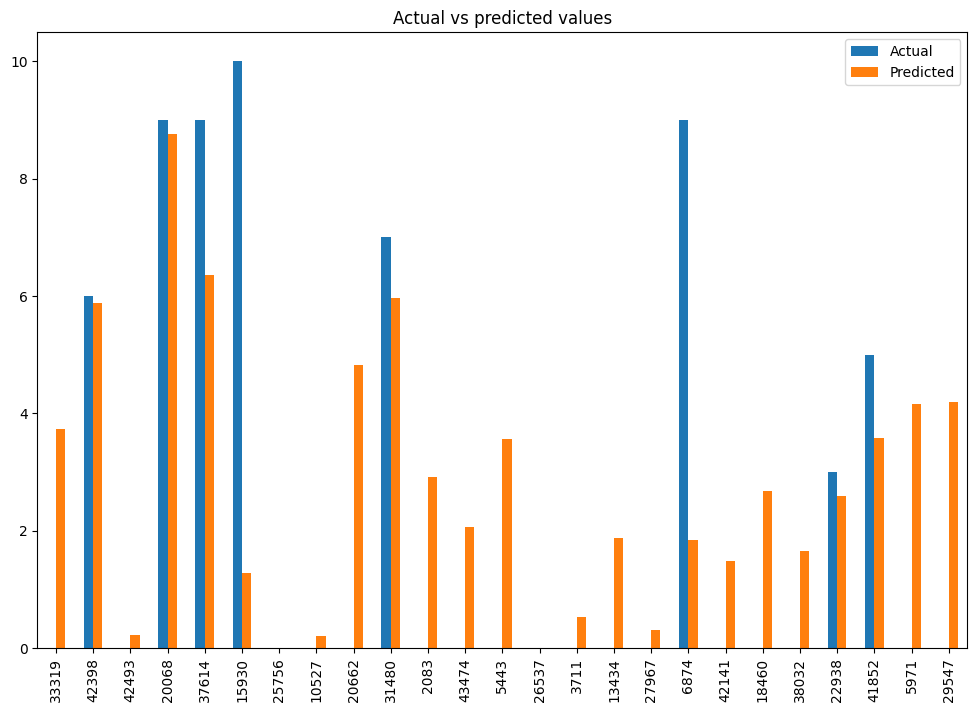

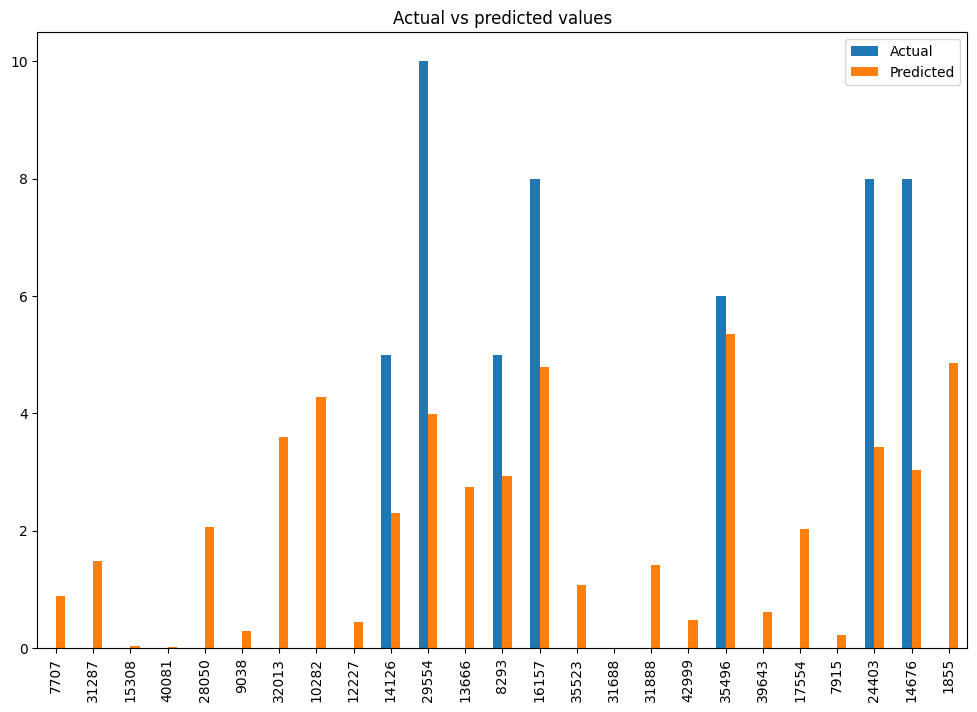

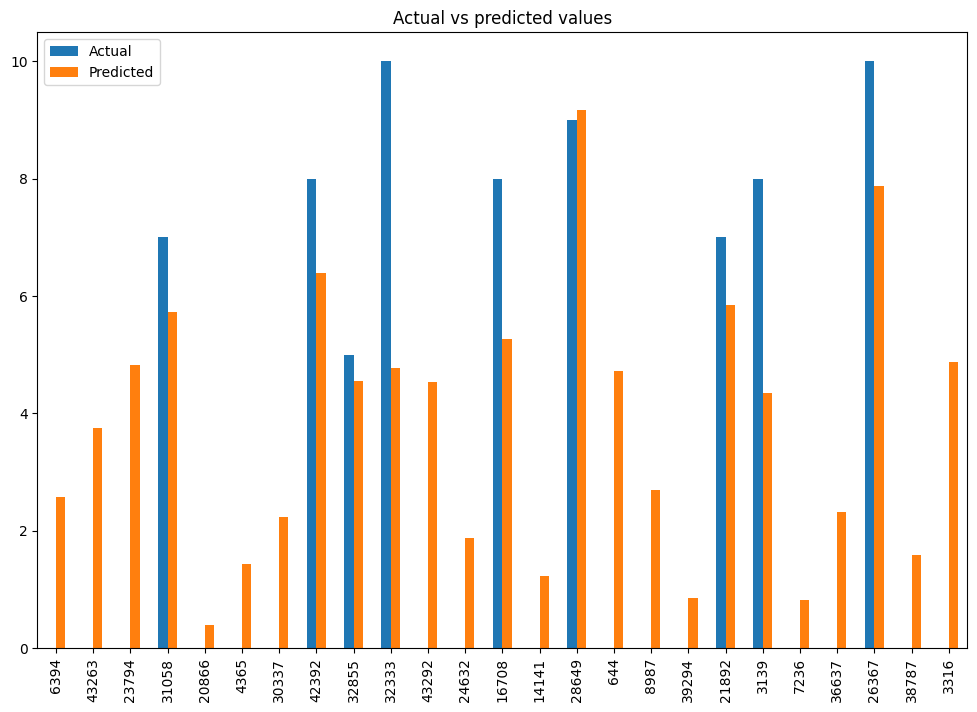

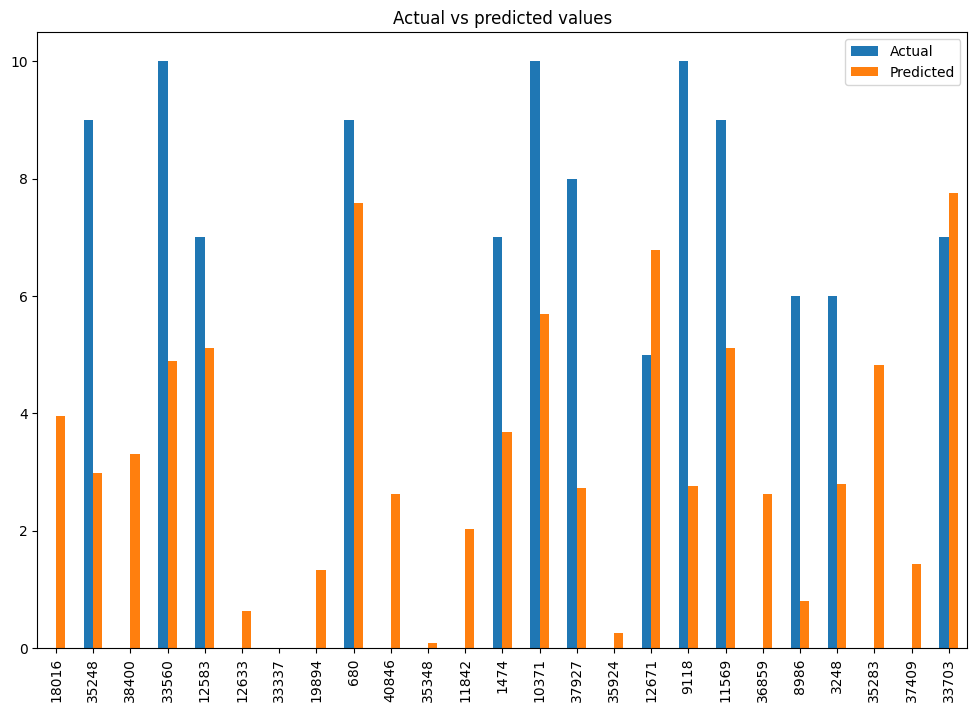

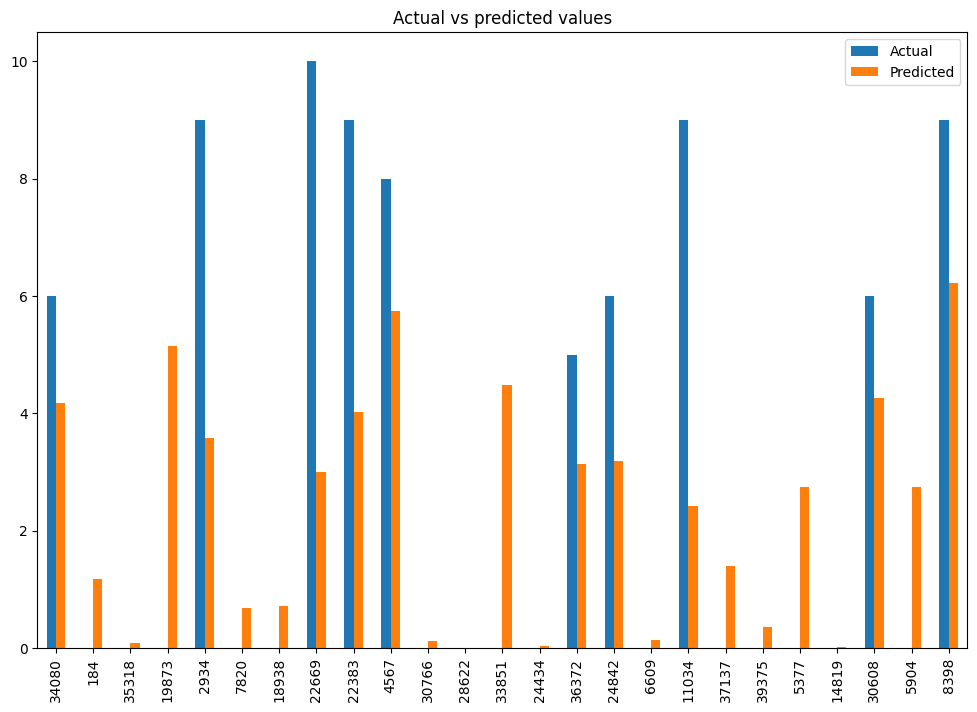

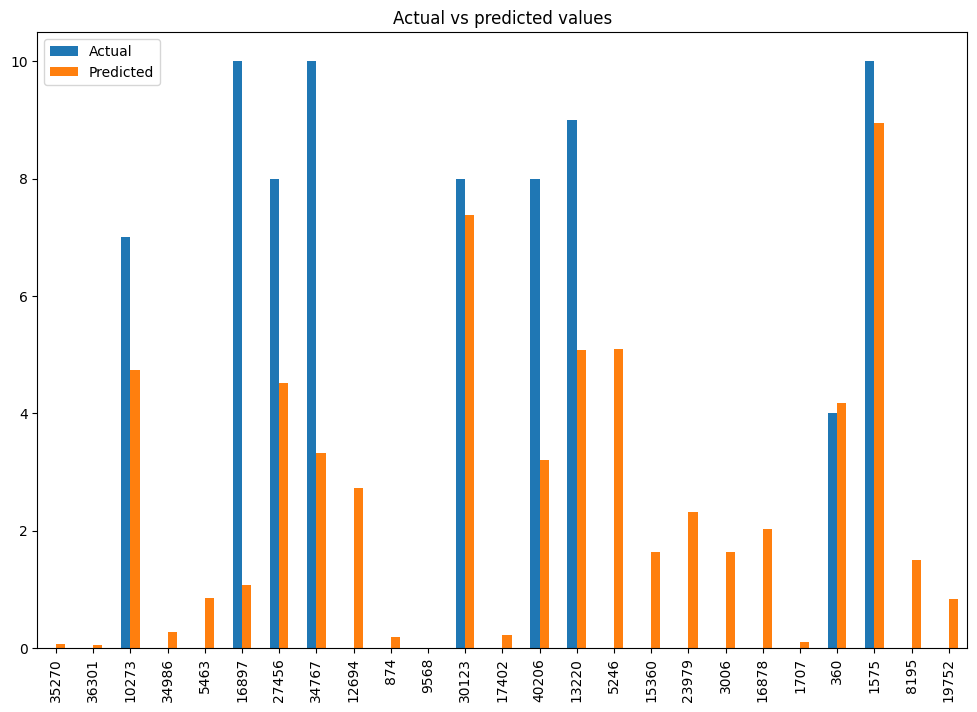

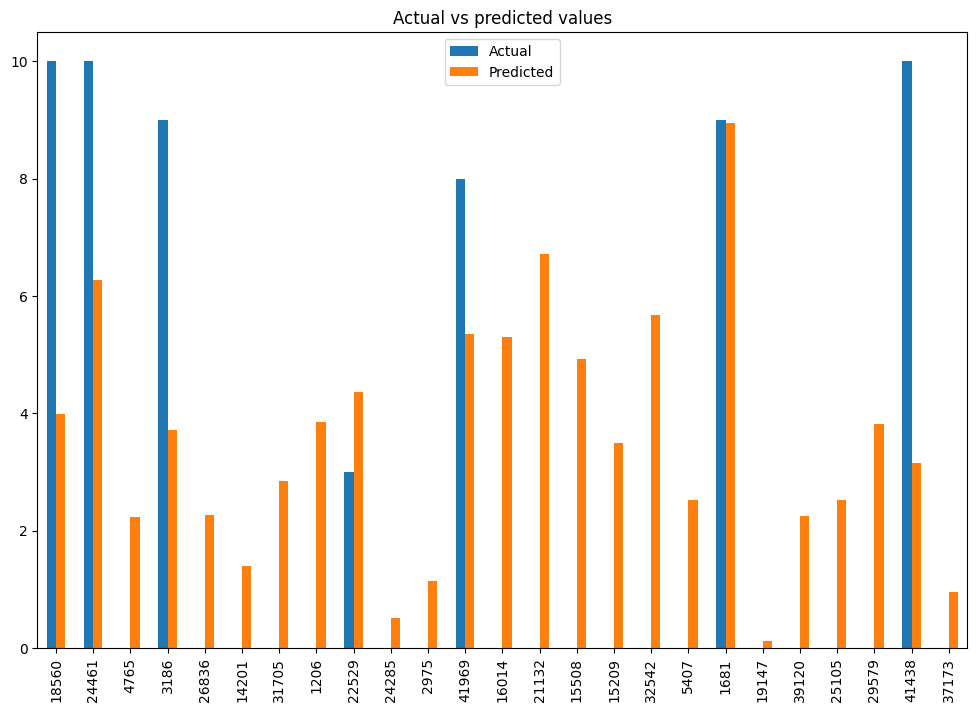

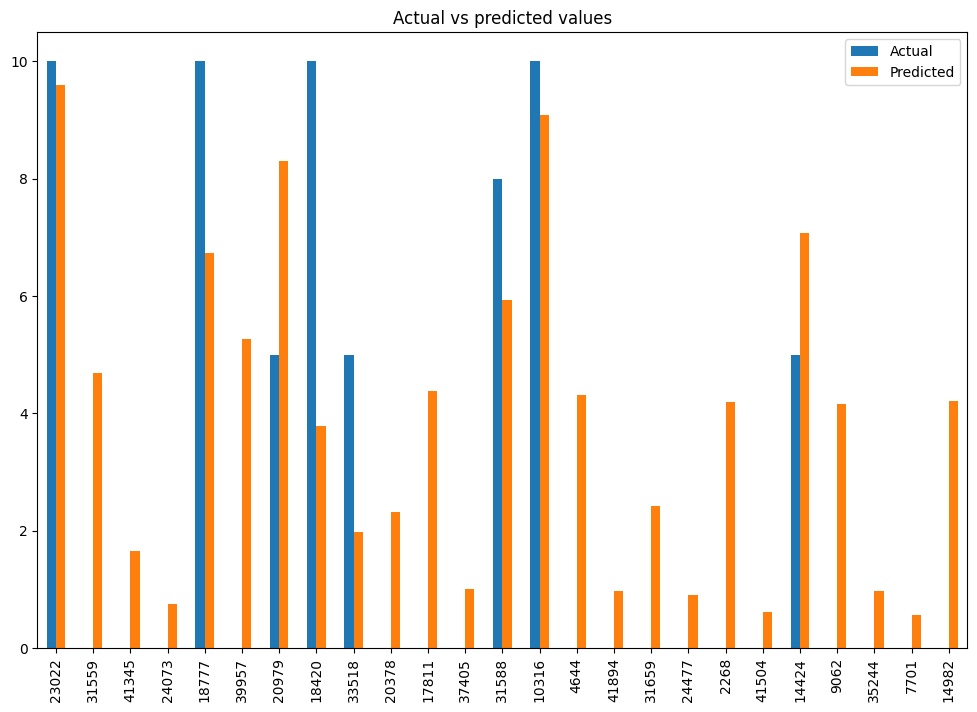

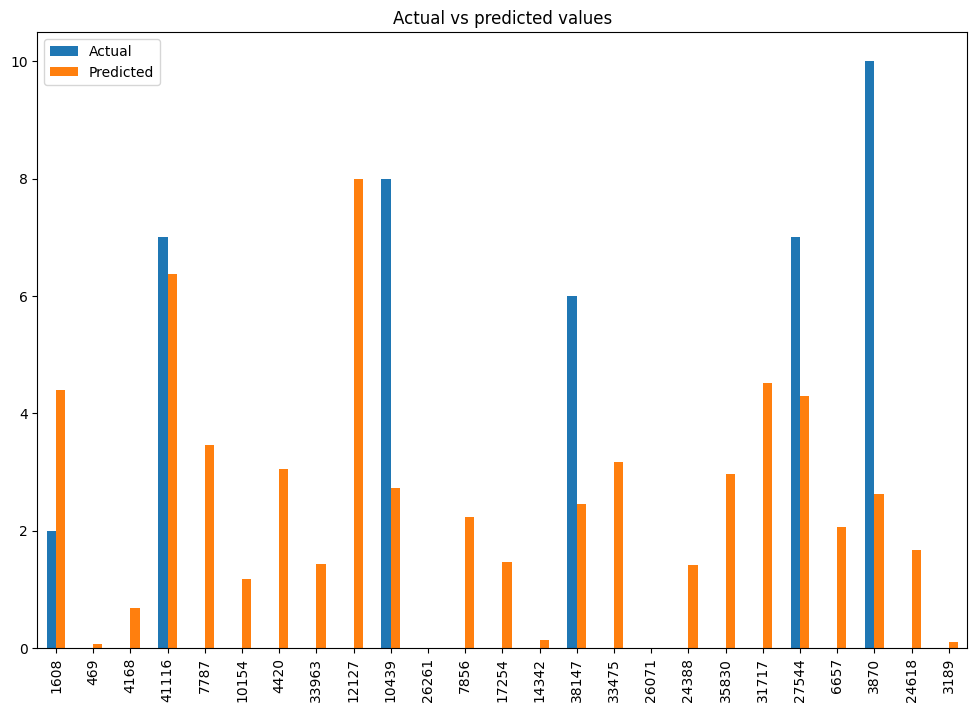

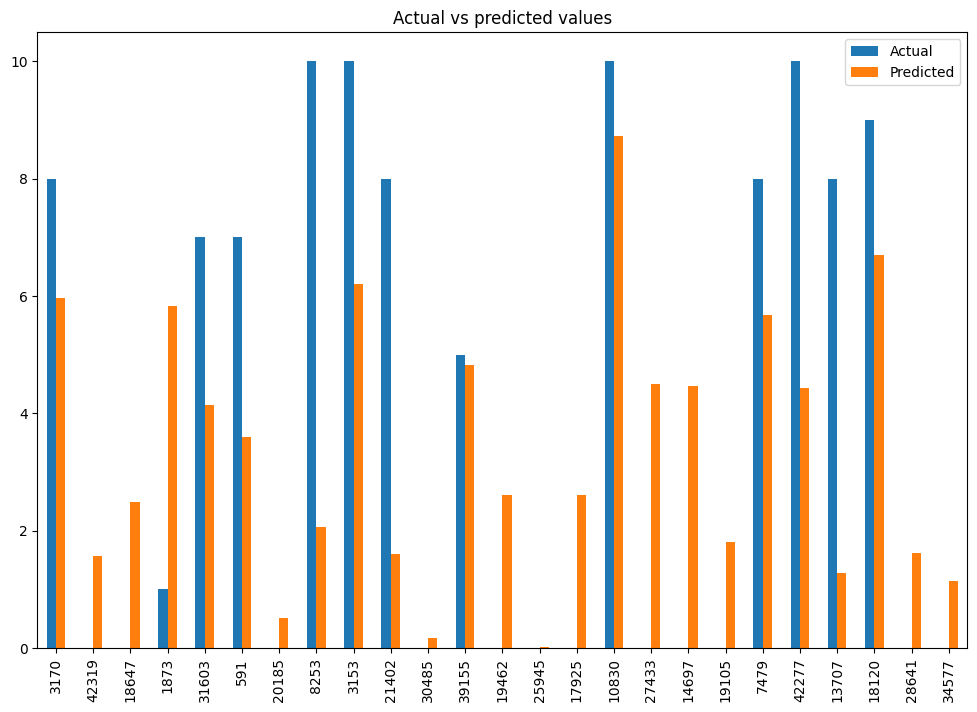

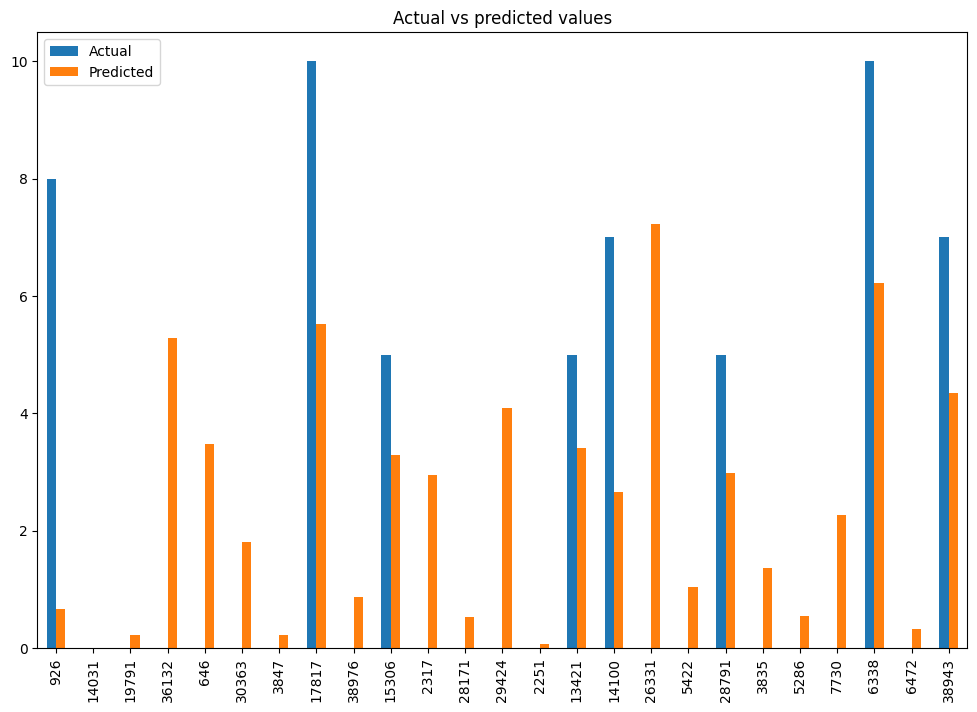

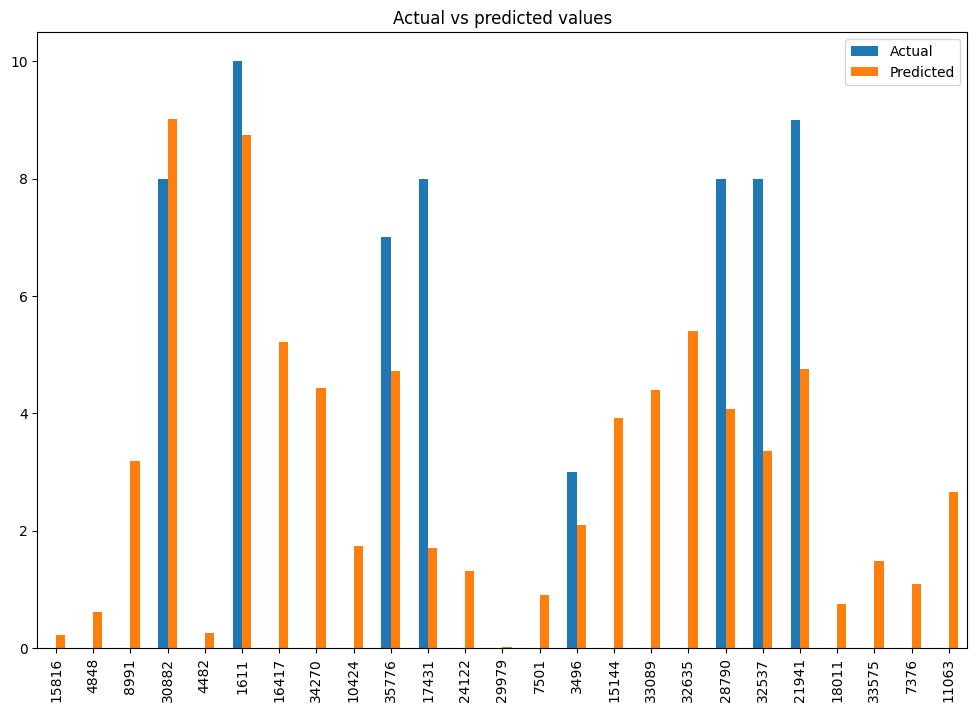

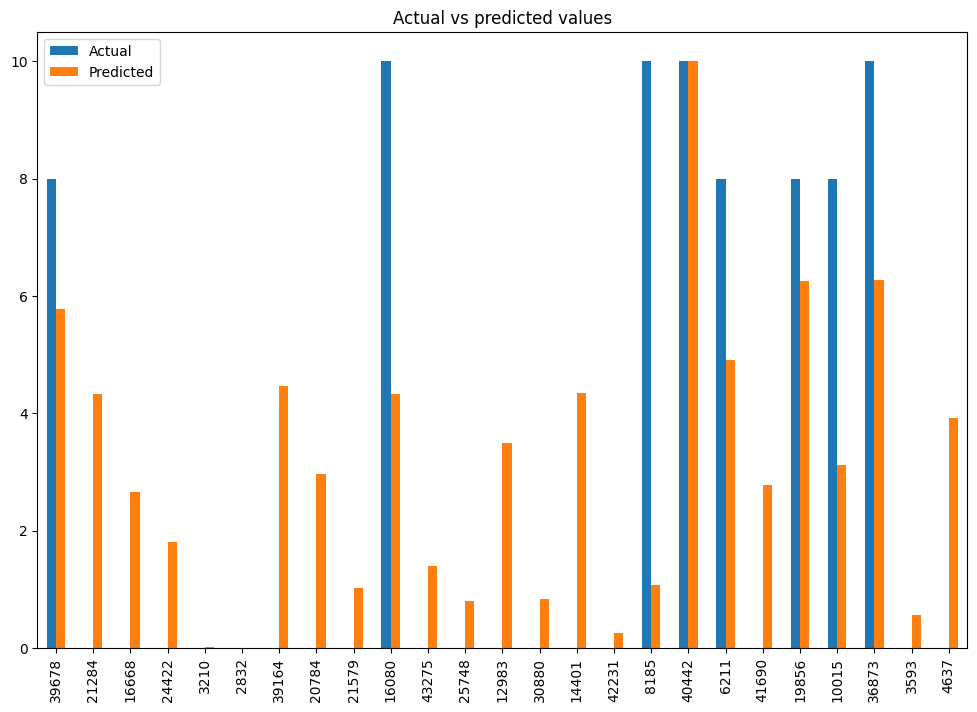

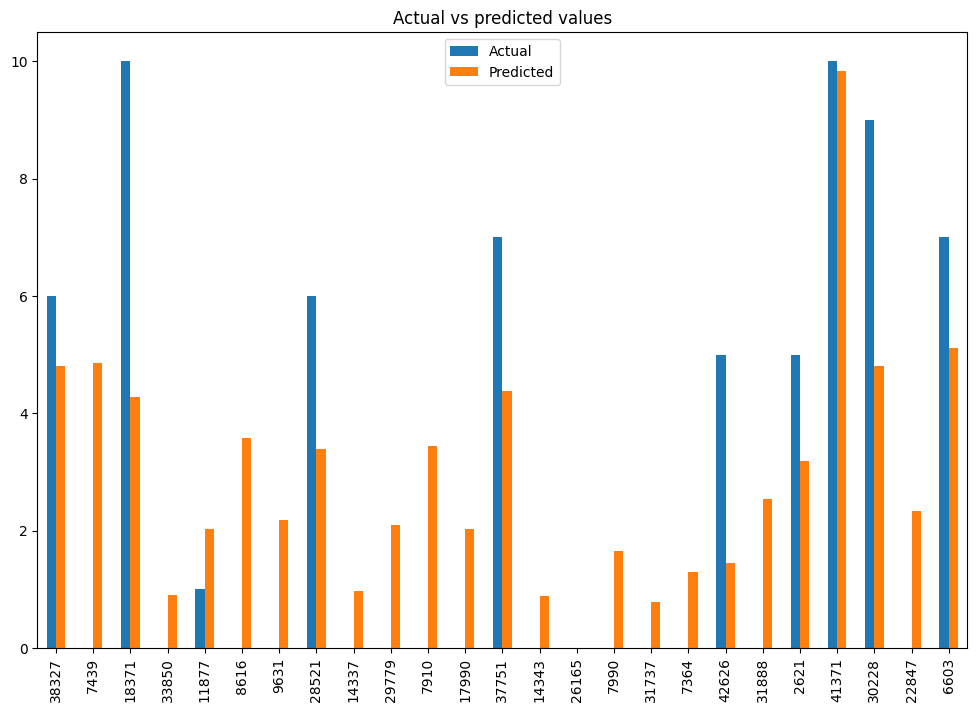

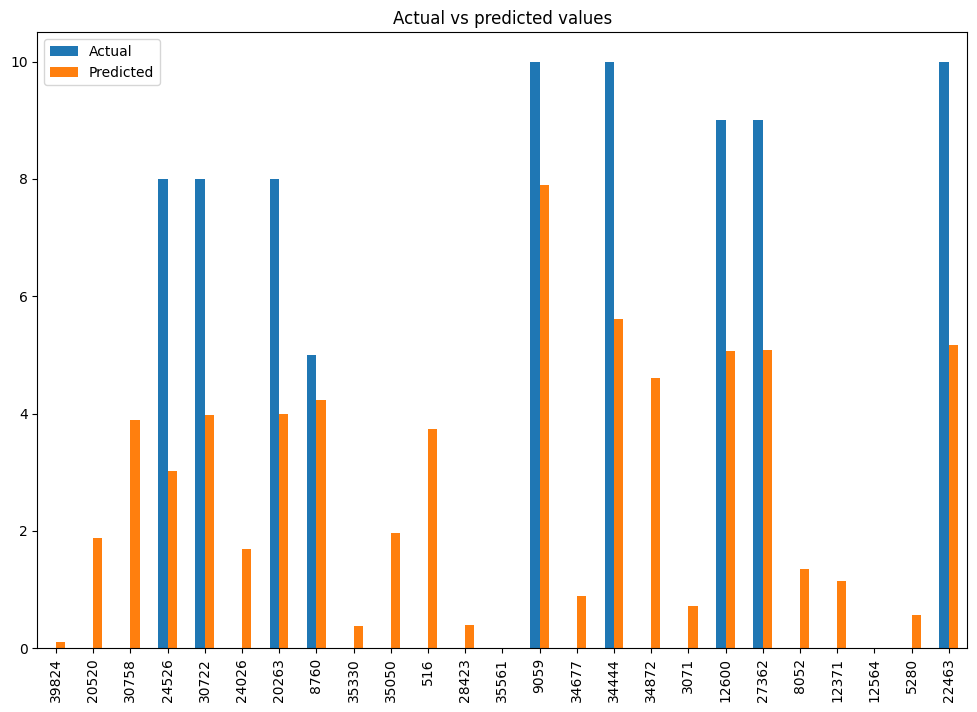

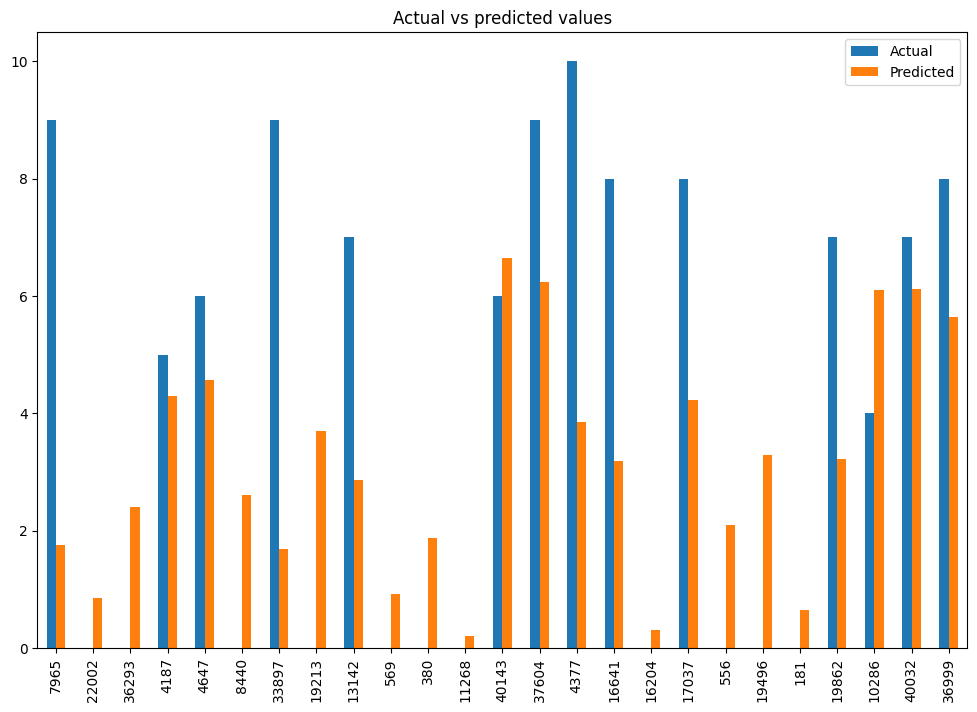

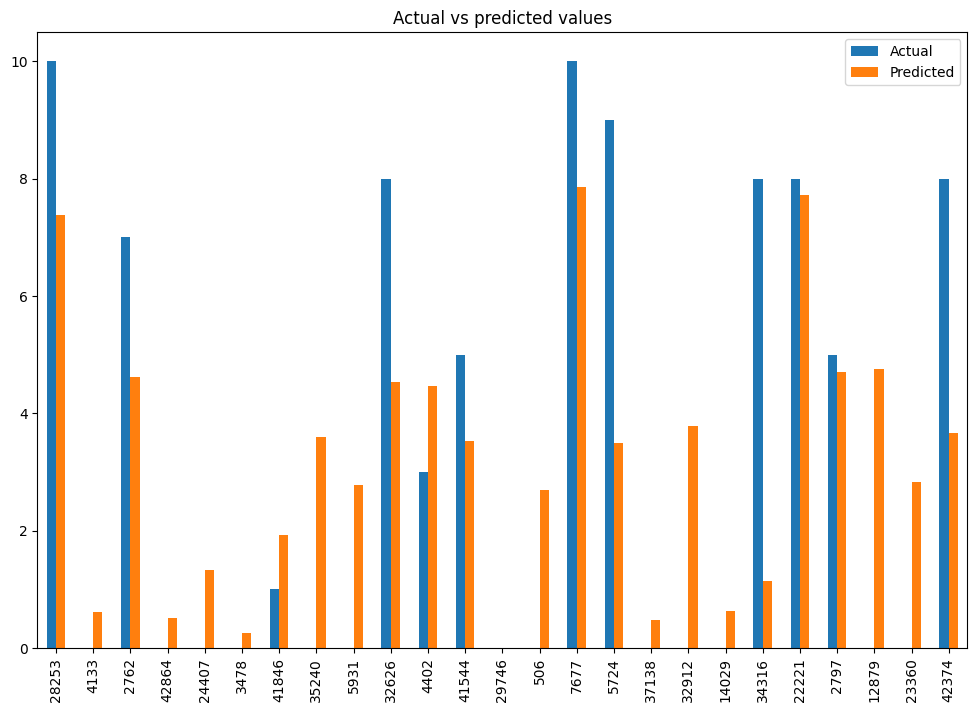

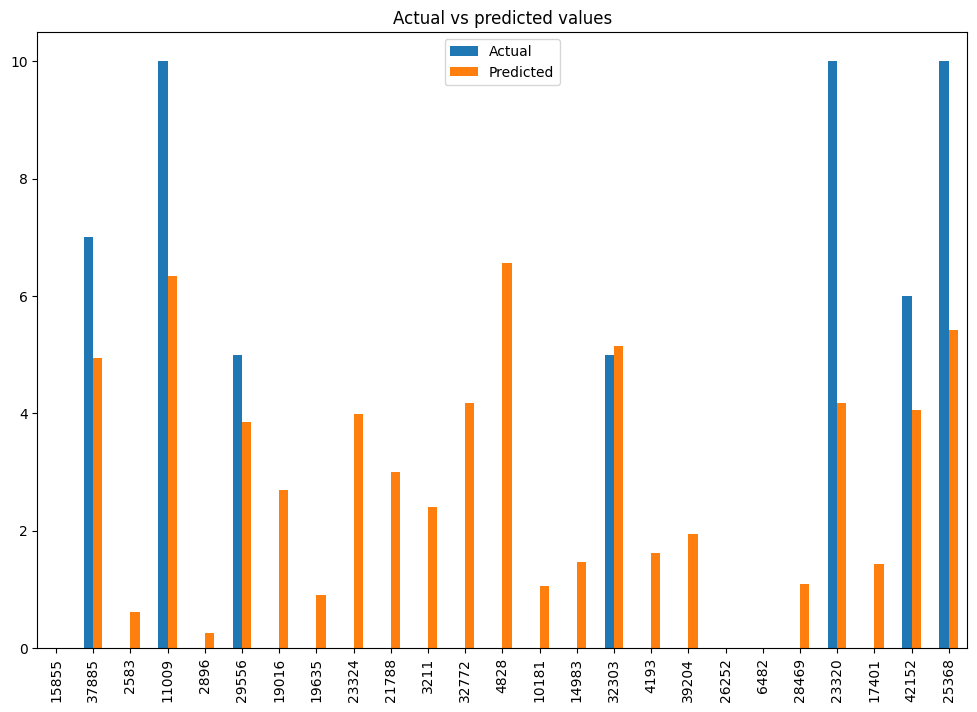

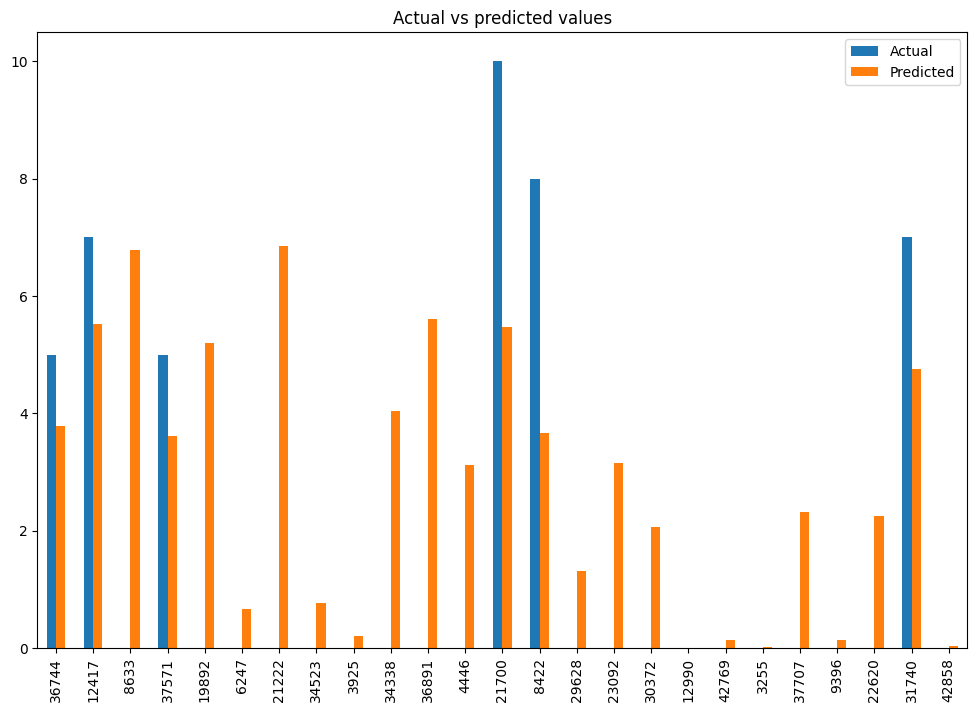

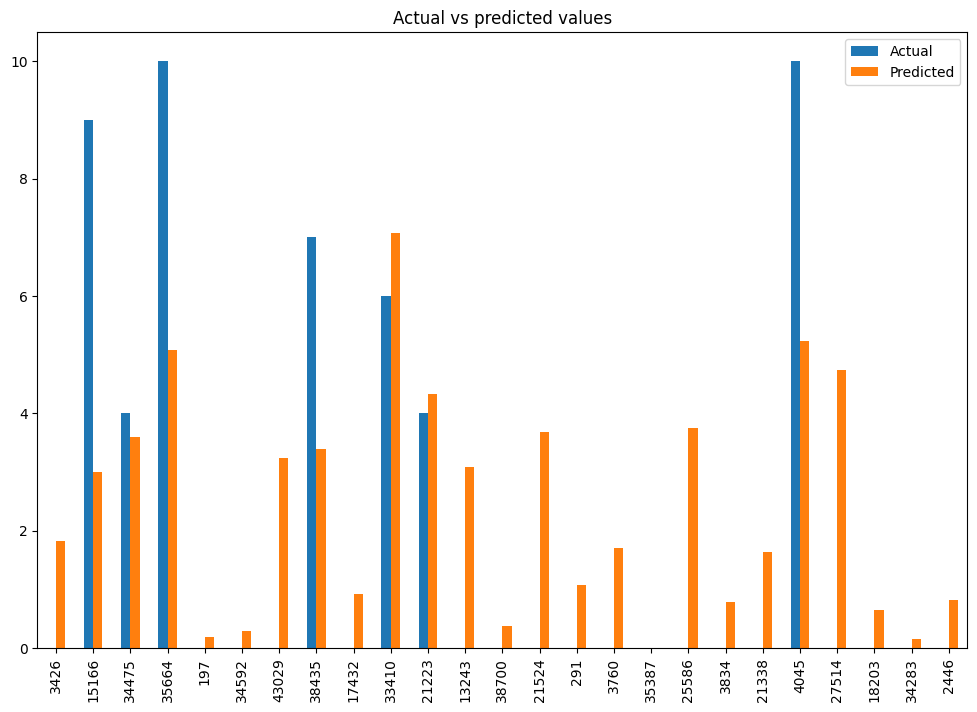

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
k = 20 # a number of folds best is 20
skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=113)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

y_valid_pred = 0*y_train
y_test_pred = 0

FEATURE = ['User-ID', 'Main_Title','Sub_Title','Book-Author','Publisher', 'City','State','Country','Age_gb']

for i, (train_index, test_index) in tqdm(enumerate(skfold.split(X_train, y_train))):
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
    X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')

    train_pool = Pool(data=X_train_fold, label=y_train_fold, cat_features=FEATURE)
    valid_pool = Pool(data=X_valid_fold, label=y_valid_fold, cat_features=FEATURE)


    print( "\nFold ", i)

    fit_model = model.fit(train_pool,
                          eval_set=valid_pool,
                          use_best_model=True
                          )
    print( "  N trees = ", model.tree_count_ )


    def score_model(model,X_train, X_test, y_train, y_test,
               show_plot=True):
        y_pred = np.clip(model.predict(X_test),0,10)
        print(f"Test score: {r2_score(y_test, y_pred)}")
        print("MSE: ", mean_squared_error(y_test, y_pred))
        print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

        predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
        if show_plot == True:
            predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
            print(predictions_comparision.sample(10))


        return {
            "test_score_r2" : r2_score(y_test, y_pred),
            "test_score_mse" : mean_squared_error(y_test, y_pred),
            "test_score_rmse" : np.sqrt(mean_squared_error(y_test, y_pred))
            }
    score_model(fit_model, X_train_fold, X_valid_fold, y_train_fold, y_valid_fold, show_plot=True)

    x_test[FEATURE] = x_test[FEATURE].astype('int')
    # Predict value Clipping
    y_test_pred +=  np.clip(fit_model.predict(x_test[X_valid_fold.columns]),0.0,10.0)

y_test_pred /= k  # Average test set predictions

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

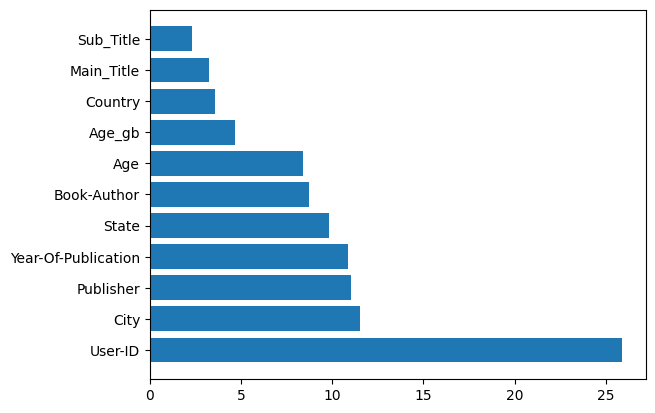

In [ ]:
cat_importance_feature = np.argsort(model.feature_importances_)[:-31:-1]
plt.barh(X_train.columns[cat_importance_feature], model.feature_importances_[cat_importance_feature])
plt.show()

In [ ]:
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['Book-Rating'] = y_test_pred
sub

,ID,Book-Rating
0,TEST_000000,5.628918
1,TEST_000001,6.505201
2,TEST_000002,6.285335
3,TEST_000003,6.001548
4,TEST_000004,5.742925
...,...,...
159616,TEST_159616,3.988447
159617,TEST_159617,3.817287
159618,TEST_159618,3.648465
159619,TEST_159619,3.782704


In [ ]:
sub.to_csv('submit_cat+20-folds+split.+split2.csv', index=False,encoding="utf-8-sig")